In [2]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
import matplotlib.pyplot as plt


In [3]:
IMG_SIZE = 64
SEQUENCE_LENGTH = 10
BASE_PATH = '/kaggle/input/cnn-lstm-hand/leapGestRecog/'

In [4]:
sequences = []
labels = []
class_names = set()

# Traverse each subject folder: 00 to 09
for subject_folder in sorted(os.listdir(BASE_PATH)):
    subject_path = os.path.join(BASE_PATH, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    for gesture_folder in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        class_names.add(gesture_folder)  # collect all unique gesture class names

# Final sorted class list
CLASSES = sorted(list(class_names))
class_to_index = {name: idx for idx, name in enumerate(CLASSES)}

# Now collect sequences from all subjects
for subject_folder in sorted(os.listdir(BASE_PATH)):
    subject_path = os.path.join(BASE_PATH, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    for gesture_folder in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        frame_files = sorted([f for f in os.listdir(gesture_path) if f.endswith('.png') or f.endswith('.jpg')])

        for i in range(0, len(frame_files) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
            frames = frame_files[i:i + SEQUENCE_LENGTH]
            seq_data = []
            for frame in frames:
                img = load_img(os.path.join(gesture_path, frame), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
                img_array = img_to_array(img) / 255.0
                seq_data.append(img_array)
            if len(seq_data) == SEQUENCE_LENGTH:
                sequences.append(seq_data)
                labels.append(class_to_index[gesture_folder])


In [5]:
# Prepare dataset
X = np.array(sequences)
y = to_categorical(labels, num_classes=len(CLASSES))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Build model
model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 1)),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_5 (TimeDistributed) │ (None, 10, 62, 62, 32)      │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 29, 29, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 12544)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │       3,227,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,251,530 (12.40 MB)

 Trainable params: 3,251,530 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_val, y_val)
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 136s 678ms/step - accuracy: 1.0000 - loss: 8.5129e-06 - val_accuracy: 0.9975 - val_loss: 0.0102
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 136s 683ms/step - accuracy: 1.0000 - loss: 7.6235e-06 - val_accuracy: 0.9950 - val_loss: 0.0094
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 134s 672ms/step - accuracy: 1.0000 - loss: 6.6979e-06 - val_accuracy: 0.9950 - val_loss: 0.0099
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 134s 669ms/step - accuracy: 1.0000 - loss: 6.0458e-06 - val_accuracy: 0.9950 - val_loss: 0.0107
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 1.0000 - loss: 5.3968e-06 - val_accuracy: 0.9950 - val_loss: 0.0097
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 1.0000 - loss: 4.9942e-06 - val_accuracy: 0.9950 - val_loss: 0.0120
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 655ms/step - accuracy: 1.0000 - loss: 4.5910e-06 - val_accuracy: 0.9950 - val_loss: 0.0102
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 134s 670

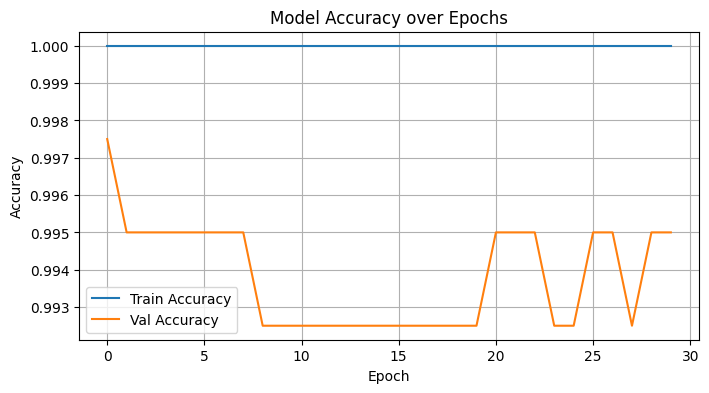

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

# Plot accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

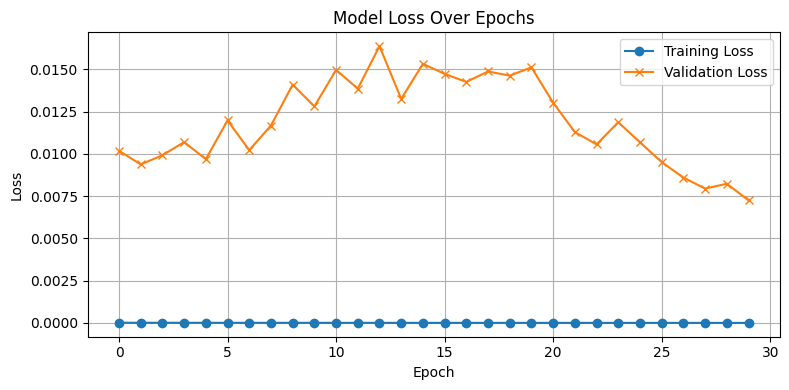

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step


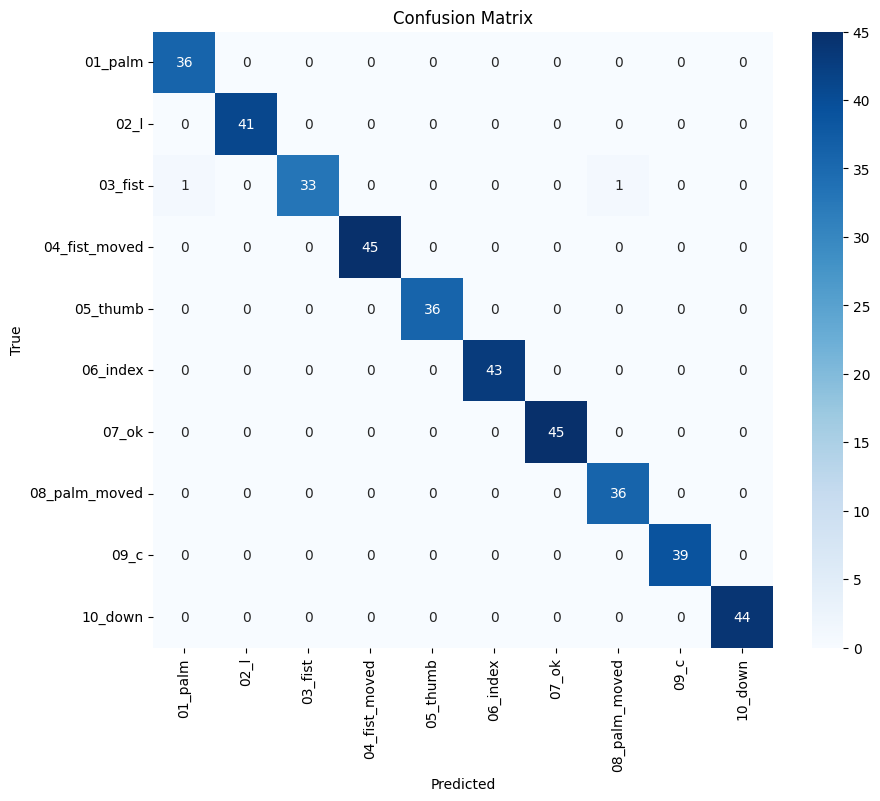

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

Classification Report:
               precision    recall  f1-score   support

      01_palm       0.97      1.00      0.99        36
         02_l       1.00      1.00      1.00        41
      03_fist       1.00      0.94      0.97        35
04_fist_moved       1.00      1.00      1.00        45
     05_thumb       1.00      1.00      1.00        36
     06_index       1.00      1.00      1.00        43
        07_ok       1.00      1.00      1.00        45
08_palm_moved       0.97      1.00      0.99        36
         09_c       1.00      1.00      1.00        39
      10_down       1.00      1.00      1.00        44

     accuracy                           0.99       400
    macro avg       0.99      0.99      0.99       400
 weighted avg       1.00      0.99      0.99       400



In [17]:
def predict_from_image_path(image_path):
    folder_path = os.path.dirname(image_path)  # Path to gesture folder like '03_fist'
    gesture_folder = os.path.basename(folder_path)  # e.g., '03_fist'
    
    frame_files = sorted(os.listdir(folder_path))[:SEQUENCE_LENGTH]

    frames = []
    for file in frame_files:
        img = load_img(os.path.join(folder_path, file), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0
        frames.append(img_array)

    if len(frames) < SEQUENCE_LENGTH:
        print("Not enough frames in this folder.")
        return

    input_seq = np.expand_dims(np.array(frames), axis=0)  # Shape: (1, SEQ_LEN, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(input_seq)
    class_idx = np.argmax(prediction)

    predicted_class = CLASSES[class_idx]  # Will be like '03_fist'

    # Extract just the gesture name (after the number)
    gesture_name = '_'.join(predicted_class.split('_')[1:])  # Handles cases like '04_fist_moved'
    print("Predicted Gesture:", gesture_name)

    # Show the first frame for reference
    plt.figure(figsize=(4, 4))
    plt.imshow(frames[0].squeeze(), cmap='gray')
    plt.title("Sample Frame for Prediction", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return gesture_name


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Gesture: fist_moved


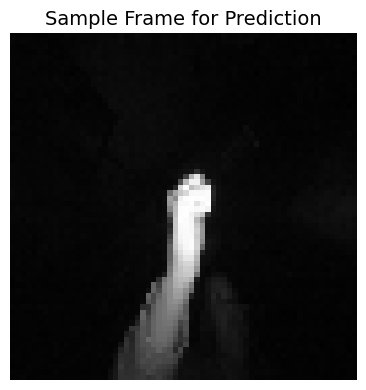

'fist_moved'

In [18]:
predict_from_image_path('/kaggle/input/cnn-lstm-hand/leapGestRecog/02/04_fist_moved/frame_02_04_0007.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Gesture: l


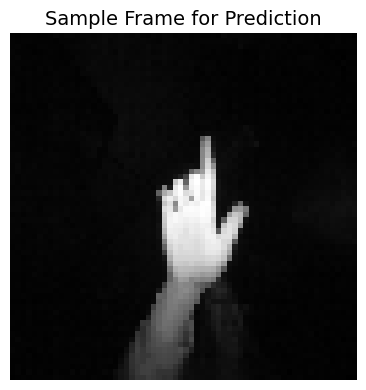

'l'

In [19]:
predict_from_image_path('/kaggle/input/cnn-lstm-hand/leapGestRecog/02/02_l/frame_02_02_0011.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Gesture: palm_moved


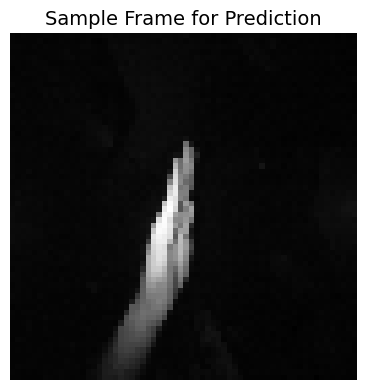

'palm_moved'

In [20]:
predict_from_image_path('/kaggle/input/cnn-lstm-hand/leapGestRecog/06/08_palm_moved/frame_06_08_0011.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Gesture: thumb


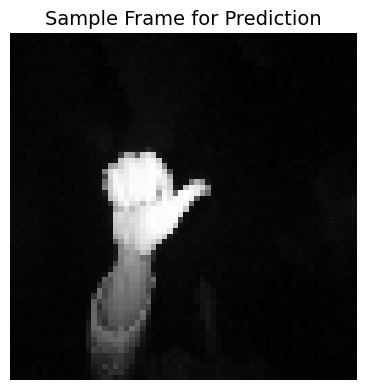

'thumb'

In [21]:
predict_from_image_path('/kaggle/input/cnn-lstm-hand/leapGestRecog/07/05_thumb/frame_07_05_0011.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Gesture: palm


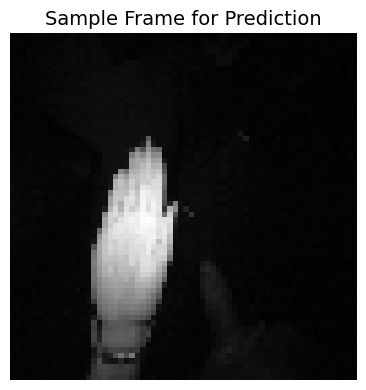

'palm'

In [22]:
predict_from_image_path('/kaggle/input/cnn-lstm-hand/leapGestRecog/08/01_palm/frame_08_01_0006.png')